In [197]:
#ипмпорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

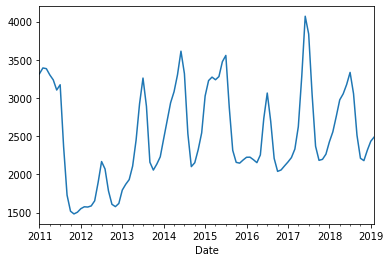

In [198]:
#чтение данных из файла + постройка графика
way = 'dz2.xlsx'
sb_data  = pd.read_excel(way , sheet_name='Sheet2', parse_dates = ['Date'])
sb_series = sb_data.drop('Region',axis =1 ).set_index('Date').squeeze().asfreq('M')
sb_series.plot()

In [199]:
validation_split_sb = sb_series.iloc[-12:]
train_split_sb = sb_series[~sb_series.index.isin(validation_split_sb.index)]

In [200]:
#строим модель и смотрим ошибку
forecast_sb = SARIMAX(
    endog = train_split_sb, 
    order = (3,1,1), 
    seasonal_order = (3,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit().forecast(len(validation_split_sb))
print(f' MAPE: {abs(forecast_sb / sb_series - 1).mean():.3%}')
forecast_sb = forecast_sb.squeeze().asfreq('M')


 MAPE: 8.085%


In [201]:
#чтение данных из файла
gosbs_data  = pd.read_excel('dz2.xlsx', sheet_name='Sheet1', parse_dates = ['Date'])
metric_columns = ['Region']
results = []

In [202]:
#кракен
for key, metric in gosbs_data.groupby(by=metric_columns):
    key = dict(zip(metric_columns,key))
    metric = metric.drop(metric_columns, axis = 1).set_index('Date')
    dataset = metric.join(sb_series.to_frame('sb_val')).dropna().sort_index()
    validation_split_gosb = dataset.iloc[-6:]
    train_split_gosb = dataset[~dataset.index.isin(validation_split_sb.index)]
    X = train_split_gosb.sb_val.values.reshape(-1,1)
    y = train_split_gosb.val.values.reshape(-1,1)
    predict_x = validation_split_sb

    gosb_forecast = LinearRegression().fit(X, y).predict(predict_x.values.reshape(-1, 1))
    gosb_forecast = gosb_forecast.flatten()
    gosb_forecast = pd.Series(gosb_forecast, predict_x.index)
    
    metric = metric.rename(columns = {'val':'actual'})
    result = metric.join(gosb_forecast.to_frame('predict'))
    result['error'] = result.apply(lambda x: abs(x['predict'] / x['actual'] - 1) , axis = 1)
    result = result.assign(**key)
    results += result.reset_index().to_dict('r')
results_df = pd.DataFrame(results)

In [203]:
#выгрузка данных 
results_df = results_df.dropna()
way = 'result.xlsx'
results_df.to_excel(way, index=False)

In [211]:
#кракен
results2 = []
i=0
for key, metric in gosbs_data.groupby(by=metric_columns):
    key = dict(zip(metric_columns,key))
    metric = metric.drop(metric_columns, axis = 1).set_index('Date')
    dataset = metric.join(forecast_sb.to_frame('sb').sort_index()).dropna().sort_index()
    train_split_gosb = dataset.iloc[-6:]
    X = train_split_gosb.sb.values.reshape(-1,1)
    y = train_split_gosb.val.values.reshape(-1,1)
    predict_x = dataset.iloc[-6:]
    
    gosb_forecast = LinearRegression().fit(X, y).predict(predict_x.values.reshape(-1, 1))
    gosb_forecast = gosb_forecast.flatten()
    gosb_forecast = pd.Series(gosb_forecast, forecast_sb.index)
    
    metric = metric.rename(columns = {'val':'actual'})
    result = metric.join(gosb_forecast.to_frame('predict'))
    result['error'] = result.apply(lambda x: abs(x['predict'] / x['actual'] - 1) , axis = 1)
    result = result.assign(**key)
    results2 += result.reset_index().to_dict('r')
    i +=1
    print(i)
results2_df = pd.DataFrame(results2)
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [207]:
#выгрузка данных 
results2_df = result2s_df.dropna()
way = 'result2.xlsx'
results_df.to_excel(way, index=False)